# AIM
- EDA
- How are PHQ scores distributed within subjects?
- i.e. Within each subject, are the scores distributed equally between depressed and non-depressed?

# FINDINGS
- Using 10 as the cutoff score for depression, quite a number of subjects have their PHQ records either mostly depressed or mostly non-depressed, rather than a balanced distribution between depressed and non-depressed.

# Modules

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import datetime as dt


from import_data import *
from mappings import *
import seaborn as sns; sns.set_theme()

# Import data

In [3]:
proj_dir = Path('.') / '..' / '..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir =  proj_dir/'data'/'clean'
viz_dir = proj_dir/'viz'

phqs, slps, metadata = import_data(source_data_dir)

# Clean data

## EDA

## Find patient with sufficient samples

In [ ]:
counts = pd.merge(
    phqs['pid'].value_counts().pipe(vc2df),
    slps['pid'].value_counts().pipe(vc2df), 
    on='pid', how='outer', suffixes=['_phq', '_slp'])

counts.fillna(0)

fig = px.scatter(counts, x="count_phq", y="count_slp", hover_name="pid")
fig.show()


In [ ]:
pid_selected = counts.loc[(counts['count_phq']==28) & (counts['count_slp']==13522),'pid'].item()

In [ ]:
slps['time'] = pd.to_datetime(slps['time'])
phqs['time'] = pd.to_datetime(phqs['time'])

phq = phqs.loc[phqs['pid']==pid_selected, :]
slp = slps.loc[slps['pid']==pid_selected, :]


In [ ]:
phq.value_counts('phq')
slp.value_counts('stages')

In [ ]:
df = slp[slp['time'].dt.strftime('%Y-%m-%d') == '2018-11-12']

In [ ]:
df = df.sort_values('time')
row = df.iloc[0]
pd.date_range(start=row['time'], end=row['time']+dt.timedelta(seconds=row['duration']), freq='30s')

df['duration'].sum()

print(pid_selected)

## Patient metadata

In [ ]:
patients_file = data_dir / 'radar_mdd_ids.xlsx'
patients = pd.read_excel(patients_file) 

In [ ]:
patients.drop(columns=['Unnamed: 11'])
flags = patients.columns[patients.columns.str.contains('flag')]
patients.loc[:, flags].isnull().sum()

In [ ]:
for flag in flags:
    print(patients[flag].value_counts(dropna=False), end='\n\n')

## PHQ

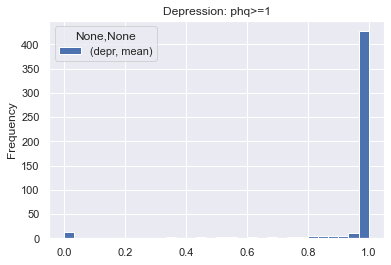

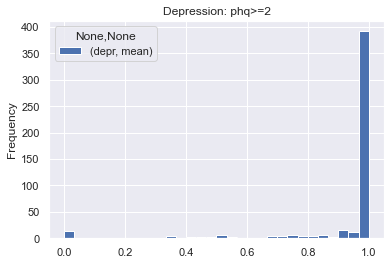

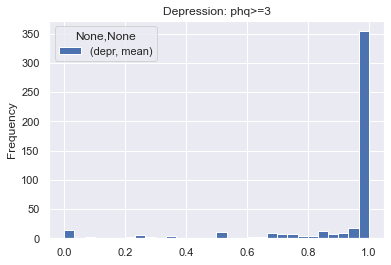

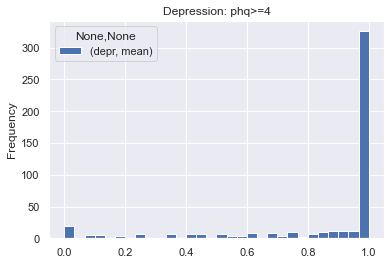

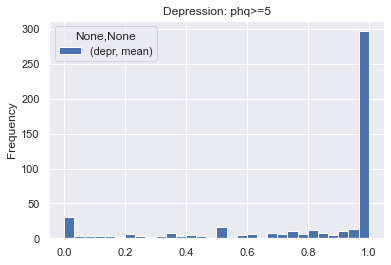

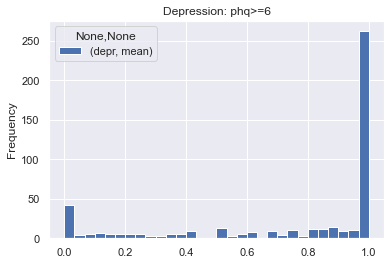

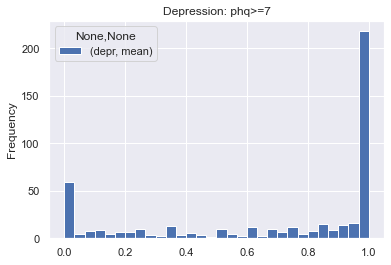

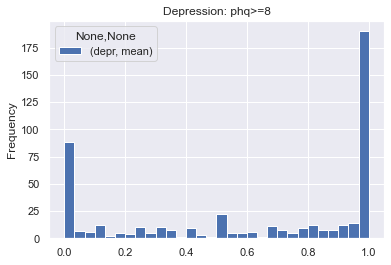

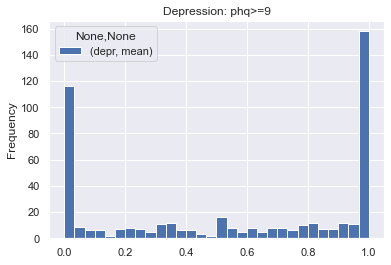

In [4]:

for cutoff in range(1, 10):
    phqs['depr'] = phqs['phq'] >= cutoff
    ax = phqs[['pid', 'depr']].groupby(['pid']).agg(['mean']).plot.hist(bins=30)
    ax.set_title('Depression: phq>=' + str(cutoff))

In [ ]:
len(phqs['pid'].unique())

In [ ]:
cutoff = 10
class_imbalance_margin = 0.2

phqs['depr'] = phqs['phq'] >= cutoff

aggregates = phqs[['pid', 'depr']].groupby(['pid']).agg(['mean', 'count'])
aggregates.columns = ['mean', 'count']

aggregates["deprCat"] = pd.cut(aggregates['mean'], [-100, 0, 0.5-class_imbalance_margin, 0.5+class_imbalance_margin, 0.999, 1], include_lowest=True)


for normalize in [True, False]:
    ax = aggregates.value_counts('deprCat', normalize=normalize, sort=False).plot.bar(title='Patients by proportion of responses with PHQ>=10')
    ax.set(xlabel='Patient\'s proportion of PHQ response >= cutoff', ylabel='proportion of patients')
    plt.show()

In [22]:
cutoff = 10
class_imbalance_margin = 0.05

phqs['depr'] = phqs['phq'] >= cutoff

aggregates = phqs[['pid', 'depr']].groupby(['pid']).agg(['mean', 'count'])
aggregates.columns = ['mean', 'count']

aggregates["deprCat"] = pd.cut(aggregates['mean'], [-100, 0, 0.5-class_imbalance_margin, 0.5+class_imbalance_margin, 0.999, 1], include_lowest=True)

In [26]:
deprCat_select = pd.Interval(0.45, 0.55, closed='right')
pid_balanced = aggregates.loc[aggregates['deprCat']==deprCat_select].index

with open(clean_data_dir/'pid_balanced.txt','w') as f:
   f.write(str(pid_balanced)) 


In [ ]:
aggregates.groupby('deprCat').agg('sum')